In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
%matplotlib inline

In [2]:
messages = pd.read_csv('sms_spam.csv' ,names= ['label', 'message'])
messages.head()

,label,message
0,type,text
1,ham,Hope you are having a good week. Just checking in
2,ham,K..give back my thanks.
3,ham,Am also doing in cbe only. But have to pay.
4,spam,"complimentary 4 STAR Ibiza Holiday or £10,000 ..."


In [3]:
messages = messages.drop([0], axis=0)
messages.head()

,label,message
1,ham,Hope you are having a good week. Just checking in
2,ham,K..give back my thanks.
3,ham,Am also doing in cbe only. But have to pay.
4,spam,"complimentary 4 STAR Ibiza Holiday or £10,000 ..."
5,spam,okmail: Dear Dave this is your final notice to...


In [4]:
messages['length'] = messages['message'].apply(len)
messages.head()

,label,message,length
1,ham,Hope you are having a good week. Just checking in,49
2,ham,K..give back my thanks.,23
3,ham,Am also doing in cbe only. But have to pay.,43
4,spam,"complimentary 4 STAR Ibiza Holiday or £10,000 ...",149
5,spam,okmail: Dear Dave this is your final notice to...,161


In [5]:
messages['label'] = messages['label'].astype('category')
messages['label'] = messages['label'].cat.codes


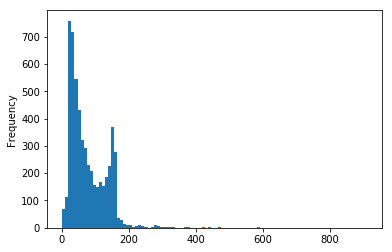

In [6]:
messages['length'].plot(bins=100,kind='hist') 


In [7]:
messages.length.describe()


count    5559.000000
mean       79.781436
std        59.105497
min         2.000000
25%        35.000000
50%        61.000000
75%       121.000000
max       910.000000
Name: length, dtype: float64

In [2]:
immessages = pd.read_csv('sms_spam.csv' ,names= ['label', 'message'])
messages[messages['length'] == 910]['message'].iloc[0]


NameError: name 'pd' is not defined

array([<matplotlib.axes._subplots.AxesSubplot object at 0x7fb860981828>,
      dtype=object)

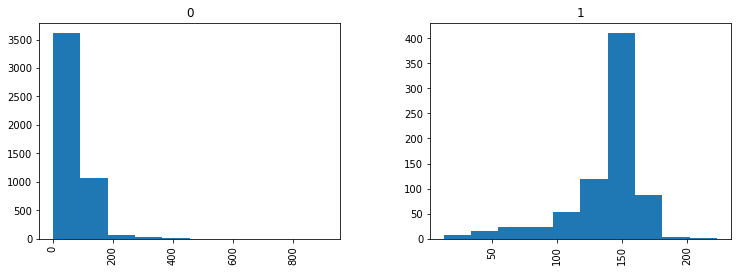

In [9]:
messages.hist(column='length', by='label',figsize=(12,4))


In [10]:
# Cleaning the texts
import re
import nltk
from nltk.corpus import stopwords
from nltk.stem.porter import PorterStemmer
corpus = []

for i in range(1, 5560):
    message = re.sub('[^a-zA-Z]', ' ', messages['message'][i])
    message = message.lower()
    message = message.split()
    ps = PorterStemmer()
    message = [ps.stem(word) for word in message if not word in set(stopwords.words('english'))]
    message = ' '.join(message)
    corpus.append(message)

In [11]:
from sklearn.feature_extraction.text import TfidfVectorizer

cv = TfidfVectorizer()
x = cv.fit_transform(corpus).toarray()
y = messages.iloc[:, 0].values

In [12]:
# Splitting the dataset into the Training set and Test set
from sklearn.model_selection import train_test_split
x_train, x_test, y_train, y_test = train_test_split(x, y, test_size = 0.20, random_state = 0)

In [13]:
from sklearn.model_selection import RepeatedKFold 
kf = RepeatedKFold(n_splits=5, n_repeats=10, random_state=None) 

for train_index, test_index in kf.split(x):
      x_train, x_test = x[train_index], x[test_index] 
      y_train, y_test = y[train_index], y[test_index]

# Naive Bayes

In [14]:
#Fitting Naive Bayes to the Training set

from sklearn.naive_bayes import GaussianNB
gnb = GaussianNB()
gnb.fit(x_train, y_train)
y_pred = gnb.predict(x_test)


In [15]:
# Predicting the Test set results
from sklearn.metrics import accuracy_score
from sklearn.metrics import classification_report

accuracy = accuracy_score(y_test, y_pred)
print("Accuracy: {:.2f}".format(accuracy))
report = classification_report(y_test, y_pred, labels=None)
print(report)

Accuracy: 0.85
              precision    recall  f1-score   support

           0       0.98      0.84      0.91       954
           1       0.49      0.92      0.64       157

   micro avg       0.85      0.85      0.85      1111
   macro avg       0.74      0.88      0.77      1111
weighted avg       0.91      0.85      0.87      1111



# Adaboost

In [16]:
from sklearn.ensemble import AdaBoostClassifier

abc = AdaBoostClassifier(n_estimators=10, learning_rate=1)
abc.fit(x_train,y_train)
y_pred = abc.predict(x_test)


In [17]:
# Predicting the Test set results
from sklearn.metrics import accuracy_score
from sklearn.metrics import classification_report

accuracy = accuracy_score(y_test, y_pred)
print("Accuracy: {:.2f}".format(accuracy))
report = classification_report(y_test, y_pred, labels=None)
print(report)

#1: spam
#0:ham

Accuracy: 0.94
              precision    recall  f1-score   support

           0       0.95      0.98      0.97       954
           1       0.88      0.68      0.77       157

   micro avg       0.94      0.94      0.94      1111
   macro avg       0.91      0.83      0.87      1111
weighted avg       0.94      0.94      0.94      1111



# Receiver operating characteristic

0.9154148139246083


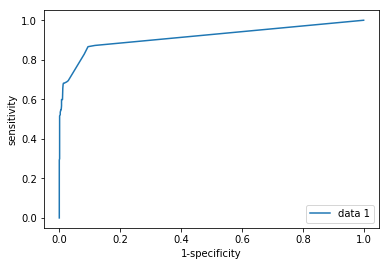

In [18]:
from sklearn.metrics import roc_curve
from sklearn.metrics import roc_auc_score


y_pred_proba = abc.predict_proba(x_test)[::,1]
fpr, tpr, _ = roc_curve(y_test,  y_pred_proba)
auc = roc_auc_score(y_test, y_pred_proba)
print(auc)
plt.plot(fpr,tpr,label="data 1")
plt.xlabel("1-specificity")
plt.ylabel("sensitivity")
plt.legend(loc=4)
plt.show()

In [25]:
def Find_Optimal_Cutoff(target, predicted):
    """ Find the optimal probability cutoff point for a classification model related to event rate
    Parameters
    ----------
    target : Matrix with dependent or target data, where rows are observations

    predicted : Matrix with predicted data, where rows are observations

    Returns
    -------     
    list type, with optimal cutoff value

    """
    fpr, tpr, threshold = roc_curve(target, predicted)
    i = np.arange(len(tpr)) 
    roc = pd.DataFrame({'tf' : pd.Series(tpr-(1-fpr), index=i), 'threshold' : pd.Series(threshold, index=i)})
    roc_t = roc.ix[(roc.tf-0).abs().argsort()[:1]]

    return list(roc_t['threshold']) 


# Add prediction probability to dataframe
data = pd.DataFrame()
data['y_test'] = y_test
data['pred_proba'] = abc.predict_proba(x_test)[:,1]

# Find optimal probability threshold
threshold = Find_Optimal_Cutoff(data['y_test'], data['pred_proba'])
print (threshold)

[0.4423258232378026]


/usr/lib/python3/dist-packages/ipykernel_launcher.py:17: DeprecationWarning: 
.ix is deprecated. Please use
.loc for label based indexing or
.iloc for positional indexing

See the documentation here:
http://pandas.pydata.org/pandas-docs/stable/indexing.html#ix-indexer-is-deprecated
